In [42]:
from torchvision.models import resnet50, ResNet50_Weights
import numpy as np
import os
from transform_factory import tensorize, center_crop_224, resize_322, imagenet_normalize, resize_224
from PIL import Image
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt

In [43]:
# config
seed = 0
data_num = 30
# expl_method = "GradCAM"
expl_method = "LayerXAct"

In [44]:
model = resnet50(weights=ResNet50_Weights.DEFAULT).eval()

In [62]:
with open(f"./val_seed_{seed}.npy", "rb") as f:
    filepath_list = np.load(f)

orig_imgs = []
orig_imgs_for_y = []
orig_expls = []


for img_path in filepath_list[:data_num]:
    img_name = os.path.basename(img_path)

    orig_img_pil = Image.open(img_path)
    orig_img = imagenet_normalize(tensorize(center_crop_224(resize_322(orig_img_pil))))
    orig_img_for_y = imagenet_normalize(tensorize(resize_224(orig_img_pil)))

    orig_imgs.append(orig_img)
    orig_imgs_for_y.append(orig_img_for_y)

    with open(f"results/val_seed_{seed}_pred_orig_eval_orig_transform_both_sign_all_reduction_sum/{img_name}_expl_{expl_method}_sample_2000_sigma_0.05_seed_{seed}_orig_true_config.npy", "rb") as f:
        orig_expl = np.load(f, allow_pickle=True)
        true_expls = np.load(f, allow_pickle=True)
        configs = np.load(f, allow_pickle=True)

        orig_expl = F.interpolate(torch.tensor(orig_expl).unsqueeze(0), (224, 224), mode='bicubic').squeeze(0).numpy()
        # orig_expl = center_crop_224(F.interpolate(torch.tensor(orig_expl).unsqueeze(0), (322, 322), mode='bicubic')).squeeze(0).numpy()

        orig_expls.append(orig_expl)


orig_imgs = torch.stack(orig_imgs)
orig_imgs_for_y = torch.stack(orig_imgs_for_y)
orig_expls = torch.tensor(np.stack(orig_expls))


In [63]:
orig_imgs.shape
orig_expls.shape
orig_imgs_for_y.shape

torch.Size([30, 3, 224, 224])

In [64]:
y = model(orig_imgs_for_y).argmax(dim = 1)

In [65]:
class AOPCTestor():
    def __init__(self, model) -> None:
        self.model = model
        self.softmax = torch.nn.Softmax(dim = 1)


    @staticmethod
    def perturbation(expl, img, ratio, mode="insertion"):
    # expl : [B, C=1, H, W]
    # img : [B, C=3, H, W]
        order = expl.flatten(1).argsort(descending=True)
        n_perturb = int(ratio * order.shape[1])
        n_order = order[:, n_perturb] 
        threshold = expl.flatten(1)[range(len(expl)), n_order]

        if mode == "insertion":
            mask = expl > threshold.reshape(len(expl), 1, 1).unsqueeze(1)
        elif mode == "deletion":
            mask = expl < threshold.reshape(len(expl), 1, 1).unsqueeze(1)        
        return (img * mask).detach()

    @staticmethod
    def conf_perturbation(expl, img, ratio, conf_high, conf_low, mode="insertion"):
        attr_order = expl.flatten(1).argsort(descending = True)
        

    def test_step(self, expl, img, label, mode="orig"):
        prob_list = []
        for ratio in np.arange(0, 1, 0.05):

            # if mode == "orig":
            img_p = self.perturbation(expl, img, ratio=ratio, mode=mode)
            # else:
                # img_p = self.conf_perturbation(expl, img, ratio=ratio)

            logit = self.model(img_p)
            prob = self.softmax(logit)

            aopc_prob = prob[range(len(label)), label].detach().mean()
            prob_list.append(aopc_prob)

        return prob_list

In [66]:
tester = AOPCTestor(model=model)
# prob_list = tester.test_step(orig_expls, orig_imgs, y, mode="insertion")
prob_list = tester.test_step(orig_expls, orig_imgs_for_y, y, mode="insertion")


In [55]:
prob_list_del = tester.test_step(orig_expls, orig_imgs, y, mode="deletion")

In [67]:
print(prob_list, torch.stack(prob_list).mean())

[tensor(0.0012), tensor(0.0413), tensor(0.1309), tensor(0.2785), tensor(0.4856), tensor(0.6312), tensor(0.7607), tensor(0.7719), tensor(0.8228), tensor(0.8693), tensor(0.8904), tensor(0.9140), tensor(0.9411), tensor(0.9506), tensor(0.9518), tensor(0.9633), tensor(0.9680), tensor(0.9746), tensor(0.9745), tensor(0.9766)] tensor(0.7149)


In [38]:
print(prob_list_del, torch.stack(prob_list_del).mean())

[tensor(0.8120), tensor(0.7673), tensor(0.7153), tensor(0.6710), tensor(0.6178), tensor(0.5611), tensor(0.5047), tensor(0.4754), tensor(0.4154), tensor(0.3272), tensor(0.2551), tensor(0.2051), tensor(0.1845), tensor(0.1582), tensor(0.1218), tensor(0.0952), tensor(0.0747), tensor(0.0557), tensor(0.0385), tensor(0.0042)] tensor(0.3530)


In [58]:
conf_highs = []
conf_lows = []

alpha = 0.05

for img_path in filepath_list[:data_num]:
    img_name = os.path.basename(img_path)
    
    with open(f"results/val_seed_{seed}_pred_orig_eval_orig_transform_both_sign_all_reduction_sum/{img_name}_expl_{expl_method}_sample_2000_sigma_0.05_seed_{seed}_results.pkl", "rb") as f:
        results = np.load(f, allow_pickle=True)

    result = results[0]

    conf_highs.append(torch.tensor(result['conf_high']))
    conf_lows.append(torch.tensor(result['conf_low']))


conf_highs = torch.stack(conf_highs)
conf_lows = torch.stack(conf_lows)

/tmp/ipykernel_1185426/3620751573.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conf_highs.append(torch.tensor(result['conf_high']))
/tmp/ipykernel_1185426/3620751573.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conf_lows.append(torch.tensor(result['conf_low']))


In [24]:
tester = AOPCTestor(model=model)
# tester.test_step(conf_lows, orig_imgs, y, mode='deletion')
high_prob_list = tester.test_step(conf_highs, orig_imgs, y, mode='deletion')


In [25]:
print(high_prob_list, torch.stack(high_prob_list).mean())


[tensor(0.8328), tensor(0.7733), tensor(0.7317), tensor(0.6671), tensor(0.6061), tensor(0.5808), tensor(0.4860), tensor(0.4285), tensor(0.3537), tensor(0.3287), tensor(0.2884), tensor(0.2428), tensor(0.2171), tensor(0.1666), tensor(0.1176), tensor(0.0797), tensor(0.0418), tensor(0.0127), tensor(0.0072), tensor(0.0100)] tensor(0.3486)


In [59]:
low_prob_list = tester.test_step(conf_highs, orig_imgs, y, mode='insertion')


In [60]:
print(low_prob_list, torch.stack(low_prob_list).mean())


[tensor(0.0012), tensor(0.0105), tensor(0.0766), tensor(0.1554), tensor(0.2122), tensor(0.2698), tensor(0.3795), tensor(0.4346), tensor(0.5180), tensor(0.5900), tensor(0.6385), tensor(0.6707), tensor(0.6889), tensor(0.7135), tensor(0.7261), tensor(0.7459), tensor(0.7724), tensor(0.7814), tensor(0.7903), tensor(0.8063)] tensor(0.4991)


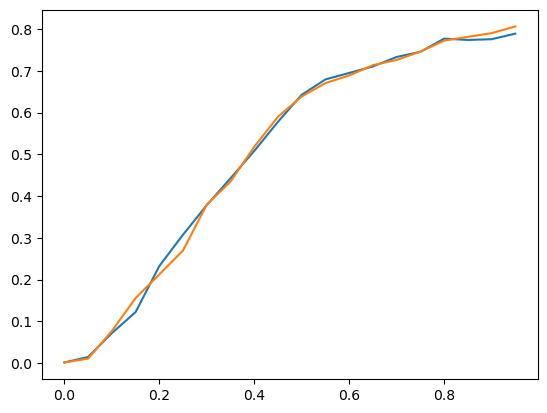

In [61]:
plt.plot(np.arange(0, 1, 0.05), prob_list)
plt.plot(np.arange(0, 1, 0.05), low_prob_list)


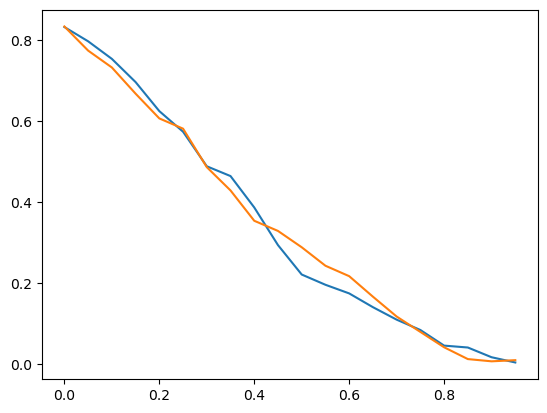

In [27]:
plt.plot(np.arange(0, 1, 0.05), prob_list_del)
plt.plot(np.arange(0, 1, 0.05), high_prob_list)